 # Import Necessary Libraries


#### The code begins by importing essential libraries and modules, laying the foundation for implementing a style transfer algorithm. PyTorch is employed for deep learning functionalities, including neural network construction and optimization. The Python Imaging Library (PIL) is used for image handling, while Matplotlib facilitates visualization. torchvision's transforms module aids in image transformations, and pre-trained models from torchvision.models support the style transfer process. NumPy is included for numerical operations, and OpenCV is utilized for computer vision tasks. Additionally, the code imports standard Python modules such as copy and math. Lastly, a function from torchvision.utils is brought in for saving images, consolidating a diverse set of tools for comprehensive style transfer implementation.

In [272]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy
import cv2
import math
from torchvision.utils import save_image

# Style Transfer Parameters and Configuration

## Style and Content Image Paths
- **STYLE_IMAGE**: Path to the style image file.
- **CONTENT_IMAGE**: Path to the content image file.

## Style Transfer Configuration
- **SMOOTH**: Boolean, whether to apply smoothing during style transfer.
- **SHOW_MASKS**: Boolean, whether to display masks during the process.
- **DEVICE**: Device for computation, automatically set to "cuda" if available, else "cpu".
- **SELECT_MATCHES**: Boolean, set to True to select color correspondences in palettes.
- **EPS**: Small value to prevent division by zero.
- **SIGMA**: Value for sigma in style transfer, typically 0.25 or 0.3.
- **PALETTE_SIZE**: Size of the color palette.
- **ADD_BLACK_WHITE**: Boolean, whether to add black and white colors to the palette.
- **STYLE_LOSS_WEIGHT**: Weight for style loss in the total loss calculation.
- **CONTENT_LOSS_WEIGHT**: Weight for content loss in the total loss calculation.
- **COLOR_DISTANCE**: Distance metric for color matching, options: 'chroma_L2', 'L2'.
- **STYLE_FEATURE_DISTANCE**: Feature distance metric for style, options: 'L2', 'COSINE'.
- **CONTENT_FEATURE_DISTANCE**: Feature distance metric for content, options: 'L2', 'COSINE'.
- **OPTIMIZER**: Optimization algorithm, options: 'LBFGS', 'Adam', 'Adagrad'.
- **LR**: Learning rate for optimization.
- **ITERATIONS**: Number of iterations for style transfer.
- **IMAGE_SIZE**: Desired size of the output image.

## Image Size and Depth Layers
- **imsize**: Desired size of the output image.
- **content_layers_default**: List of default layers for content loss computation.
- **color_aware_layers_default**: List of default layers for color awareness in style transfer.


In [274]:
# Set paths for style and content images
STYLE_IMAGE = "./s_1.jpg"
CONTENT_IMAGE = "./c_4.jpg"
# Set various parameters for the style transfer
SMOOTH = True
SHOW_MASKS = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_MATCHES = True # set to True to select color correspondences in palettes
EPS = 1e-6
SIGMA = 0.25 # 0.25 and 0.3 work well in most cases
PALETTE_SIZE = 5
ADD_BLACK_WHITE = False
STYLE_LOSS_WEIGHT = 10000
CONTENT_LOSS_WEIGHT = 1
COLOR_DISTANCE = 'chroma_L2'  # Options: 'chroma_L2', 'L2'
STYLE_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
CONTENT_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
OPTIMIZER = 'LBFGS'  # Options: 'LBFGS', 'Adam', 'Adagrad'
LR = 0.5
ITERATIONS = 250
IMAGE_SIZE = 512
# desired size of the output image
imsize = IMAGE_SIZE 
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4', 'conv_5']
color_aware_layers_default = ['conv_1','conv_2','conv_3','conv_4', 'conv_5']

# Image Processing and Color Manipulation Functions

## Convert Image into Float32 Type (to32F)

This function takes an image as input and checks if its data type is already `np.float32`. If it is, the image is returned as is. Otherwise, the function normalizes the pixel values to the range [0, 1] by dividing each pixel value by 255 and then converts the image to `np.float32` data type.

## RGB Channels of the Image (rgb)

This function ensures that the input image is in RGB format. If the image is grayscale, it is converted to a 3-channel RGB image by duplicating the single-channel intensity values across all three channels. If the image is already in RGB format, it is returned unchanged.

## RGB to Lab Color Space Conversion (rgb2Lab)

Converts an RGB image to the Lab color space using OpenCV `cv2.cvtColor` function. Lab color space separates intensity (L) from color information (a, b), making it suitable for color-related operations.

## Lab to RGB Color Space Conversion (Lab2rgb)

Converts an image from the Lab color space back to RGB using OpenCV.

## Grayscale Check (_isGray)

Checks if an image is grayscale by examining its shape. A grayscale image has only two dimensions.

## Vector and Matrix Check (isVector and isMatrix)

These functions determine whether the input is a vector (one-dimensional array) or a matrix (two-dimensional array) by comparing the size and shape.

## Vector Norm and Matrix Norm Functions (normVectors and l2NormVectors)

`normVectors` computes the L2 norm of vectors in a matrix, while `l2NormVectors` calculates the squared L2 norm. The latter is used for both vectors and matrices.

## Color Coordination (colorCoordinates)

Given color IDs, this function maps them to corresponding color coordinates within a specified color range.

## Color Densities (colorDensities)

Calculates color densities from histogram bins, ensuring positive values, and normalizes them.

## RGB Colors from Histogram Bins (rgbColors)

Extracts RGB colors from histogram bins, ensuring values are within the [0, 1] range.

## Clip Low Density Values (clipLowDensity)

Filters out low-density values in histogram bins and corresponding colors based on a specified threshold (alpha).

## Density Sizes (densitySizes)

Calculates density sizes based on color densities, adjusting them within a specified size range.

## Range to Ticks and Limits Conversion (range2ticks and range2lims)

Converts numerical ranges into suitable ticks for visualization and determines plot limits, considering a margin defined by 10% of the range.



In [275]:
## Convert image into float32 type.
def to32F(img):
    if img.dtype == np.float32:
        return img
    return (1.0 / 255.0) * np.float32(img)

## RGB channels of the image.
def rgb(img):

    if len(img.shape) == 2:
        h, w = img.shape
        img_rgb = np.zeros((h, w, 3), dtype=img.dtype)
        for ci in range(3):
            img_rgb[:, :, ci] = img
        return img_rgb

    h, w, cs = img.shape
    if cs == 3:
        return img

    img_rgb = np.zeros((h, w, 3), dtype=img.dtype)

    cs = min(3, cs)

    for ci in range(cs):
        img_rgb[:, :, ci] = img[:, :, ci]
    return img_rgb

## RGB to Lab.
def rgb2Lab(img):
    img_rgb = rgb(img)
    Lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    return Lab


## Lab to RGB.
def Lab2rgb(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return rgb


def _isGray(image):
    return len(image.shape) == 2


## True if x is a vector.
def isVector(x):
    return x.size == x.shape[0]


## True if x is a matrix.
def isMatrix(x):
    return not isVector(x)


## Norm of vectors (n x m matrix).
def normVectors(x):
    return np.sqrt(l2NormVectors(x))


## L2 norm of vectors (n x m matrix).
#  n x 1 vector: call np.square.
#  n x m vectors: call np.einsum.
def l2NormVectors(x):
    if isVector(x):
        return np.square(x)
    else:
        return np.einsum('...i,...i', x, x)

def colorCoordinates(color_ids, num_bins, color_range):
    color_ids = np.array(color_ids).T
    c_min, c_max = color_range
    color_coordinates = c_min + (
        color_ids * (c_max - c_min)) / float(num_bins - 1.0)
    return color_coordinates


def colorDensities(hist_bins):
    hist_positive = hist_bins > 0.0
    color_densities = np.float32(hist_bins[hist_positive])

    density_max = np.max(color_densities)
    color_densities = color_densities / density_max

    return color_densities


def rgbColors(hist_bins, color_bins):
    hist_positive = hist_bins > 0.0

    colors = color_bins[hist_positive, :]
    colors = np.clip(colors, 0.0, 1.0)
    return colors


def clipLowDensity(hist_bins, color_bins, alpha):
    density_mean = np.mean(hist_bins)
    low_density = hist_bins < density_mean * alpha
    hist_bins[low_density] = 0.0

    for ci in range(3):
        color_bins[low_density, ci] = 0.0


def densitySizes(color_densities, density_size_range):
    density_size_min, density_size_max = density_size_range
    density_size_factor = density_size_max / density_size_min
    density_sizes = density_size_min * np.power(
        density_size_factor, color_densities)
    return density_sizes


def range2ticks(tick_range, decimals=1):
    ticks = np.around(tick_range, decimals=decimals)
    ticks[ticks > 10] = np.rint(ticks[ticks > 10])
    return ticks


def range2lims(tick_range):
    unit = 0.1 * (tick_range[:, 1] - tick_range[:, 0])
    lim = np.array(tick_range)
    lim[:, 0] += -unit
    lim[:, 1] += unit

    return lim

 # ColorPixels Class for Image Pixel Analysis

The `ColorPixels` class facilitates pixel analysis of an input image, automatically converting it into the `np.float32` format. The class is initialized with an image and an optional parameter `num_pixels`, specifying the number of pixels for analysis (default is 1000). This class provides methods for extracting pixel values in different color spaces, including RGB and Lab.

### Methods:

1. **`__init__(self, image, num_pixels=1000)`**: The constructor initializes the `ColorPixels` object with the input image, automatically converting it to the `np.float32` format. The `num_pixels` parameter sets the number of pixels for analysis, and internal variables `_rgb_pixels`, `_Lab`, and `_hsv` are initialized as `None`.

2. **`rgb(self)`**: Returns the RGB pixel values of the image. If the pixel values have not been computed yet, it calls the `pixels` method with the "rgb" color space.

3. **`Lab(self)`**: Returns the Lab pixel values of the image. If the pixel values have not been computed yet, it calls the `pixels` method with the "Lab" color space.

4. **`pixels(self, color_space="rgb")`**: Computes and returns the pixel values of the given color space. If the color space is "Lab," the RGB image is converted to the Lab color space using the `rgb2Lab` function. The actual pixel values are obtained by calling the `_image2pixels` method.

5. **`_image2pixels(self, image)`**: This private method takes an image as input and returns a subset of pixels for analysis. For grayscale images, it reshapes the flattened array of pixel values by selecting pixels at a specified step interval. For color images, it reshapes the array of color channels and selects pixels similarly.

The `ColorPixels` class provides a convenient way to perform pixel analysis on images, offering flexibility in analyzing pixel values in different color spaces.


In [276]:
#  input image is automatically converted into np.float32 format.
class ColorPixels:

    def __init__(self, image, num_pixels=1000):
        self._image = to32F(image)
        self._num_pixels = num_pixels
        self._rgb_pixels = None
        self._Lab = None
        self._hsv = None

    ## RGB pixels.
    def rgb(self):
        if self._rgb_pixels is None:
            self._rgb_pixels = self.pixels("rgb")
        return self._rgb_pixels

    ## Lab pixels.
    def Lab(self):
        if self._Lab is None:
            self._Lab = self.pixels("Lab")
        return self._Lab

    ## Pixels of the given color space.
    def pixels(self, color_space="rgb"):
        image = np.array(self._image)

        if color_space == "Lab":
            image = rgb2Lab(self._image)

        return self._image2pixels(image)

    def _image2pixels(self, image):
        if _isGray(image):
            h, w = image.shape
            step = int(h * w / self._num_pixels)
            return image.reshape((h * w))[::step]

        h, w, cs = image.shape
        step = int(h * w / self._num_pixels)
        return image.reshape((-1, cs))[::step]

# Implementation of 3D Color Histograms

The `Hist3D` class is designed for the implementation of 3D color histograms, providing functionality to compute and analyze color distributions in an image.

### Methods:

1. **`__init__(self, image, num_bins=16, alpha=0.1, color_space='rgb')`**: The constructor initializes the `Hist3D` object with the input image and optional parameters such as the number of bins (`num_bins`), a threshold for clipping low-density values (`alpha`), and the color space for analysis (`color_space`). The target pixels are computed using the `ColorPixels` class, and color range and histograms are calculated.

2. **`colorSpace(self)`**: Returns the color space used for histogram computation.

3. **`colorIDs(self)`**: Computes and returns the indices of non-zero histogram bins.

4. **`colorCoordinates(self)`**: Retrieves the color coordinates corresponding to the non-zero histogram bins within the specified color range.

5. **`colorDensities(self)`**: Computes and returns color densities from the histogram bins.

6. **`rgbColors(self)`**: Extracts RGB colors from the histogram bins, ensuring values are within the [0, 1] range.

7. **`colorRange(self)`**: Returns the computed color range based on the target pixels.

8. **`_computeTargetPixels(self, image, color_space)`**: Computes the target pixels and RGB pixels from the input image using the `ColorPixels` class.

9. **`_computeColorRange(self)`**: Computes the color range based on the minimum and maximum values of the target pixels in each color channel.

10. **`_computeHistogram(self)`**: Computes the 3D histogram and color bins from the target pixels and RGB pixels. The histogram is initialized with zeros, and the color bins are accumulated with RGB values based on the corresponding histogram bin indices.

11. **`_clipLowDensity(self)`**: Clips low-density values in the histogram and corresponding color bins based on the specified threshold (`alpha`).

12. **`_histPositive(self)`**: Returns a boolean array indicating whether histogram bins have positive values.

The `Hist3D` class provides a comprehensive implementation for analyzing color distributions in images, allowing users to retrieve information about color space, color IDs, coordinates, densities, RGB colors, and the computed color range.

In [277]:
## Implementation of 3D color histograms.
class Hist3D:
    def __init__(self, image,
                 num_bins=16, alpha=0.1, color_space='rgb'):
        self._computeTargetPixels(image, color_space)
        self._num_bins = num_bins
        self._alpha = alpha
        self._color_space = color_space
        self._computeColorRange()
        self._computeHistogram()

    def colorSpace(self):
        return self._color_space

    def colorIDs(self):
        color_ids = np.where(self._histPositive())
        return color_ids

    def colorCoordinates(self):
        color_ids = self.colorIDs()
        num_bins = self._num_bins
        color_range = self._color_range
        return colorCoordinates(color_ids, num_bins, color_range)

    def colorDensities(self):
        return colorDensities(self._hist_bins)

    def rgbColors(self):
        return rgbColors(self._hist_bins, self._color_bins)

    def colorRange(self):
        return self._color_range

    def _computeTargetPixels(self, image, color_space):
        color_pixels = ColorPixels(image)
        self._pixels = color_pixels.pixels(color_space)
        self._rgb_pixels = color_pixels.rgb()

    def _computeColorRange(self):
        pixels = self._pixels
        cs = pixels.shape[1]

        c_min = np.zeros(cs)
        c_max = np.zeros(cs)
        for ci in range(cs):
            c_min[ci] = np.min(pixels[:, ci])
            c_max[ci] = np.max(pixels[:, ci])

        self._color_range = [c_min, c_max]

    def _computeHistogram(self):
        pixels = self._pixels
        num_bins = self._num_bins
        c_min, c_max = self._color_range

        hist_bins = np.zeros((num_bins, num_bins, num_bins), dtype=np.float32)
        color_bins = np.zeros((num_bins, num_bins, num_bins, 3), 
                              dtype=np.float32)

        color_ids = (num_bins - 1) * (pixels - c_min) / (c_max - c_min)
        color_ids = np.int32(color_ids)

        for pi, color_id in enumerate(color_ids):
            hist_bins[color_id[0], color_id[1], color_id[2]] += 1
            color_bins[color_id[0], color_id[1], 
                       color_id[2]] += self._rgb_pixels[pi]

        self._hist_bins = hist_bins
        hist_positive = self._hist_bins > 0.0

        for ci in range(3):
            color_bins[hist_positive, ci] /= self._hist_bins[hist_positive]

        self._color_bins = color_bins

        self._clipLowDensity()

    def _clipLowDensity(self):
        clipLowDensity(self._hist_bins, self._color_bins, self._alpha)

    def _histPositive(self):
        return self._hist_bins > 0.0

# Automatic Palette Selection

## PaletteSelection Class
The `PaletteSelection` class implements automatic palette selection based on color coordinates, color densities, and RGB colors. This class is initialized with color information and provides methods for obtaining the selected palette coordinates and colors.

### Methods:
#### 1. __init__(self, color_coordinates, color_densities, rgb_colors, num_colors=7, sigma=70.0):
   The constructor initializes the `PaletteSelection` object with color-related information, including color coordinates, densities, and RGB colors. The parameters `num_colors` and `sigma` set the number of colors in the palette and the sigma value for updating weights, respectively.

#### 2. paletteCoordinates(self):
   Returns the selected palette coordinates.

#### 3. paletteColors(self):
   Returns the selected palette colors.

#### 4. _compute(self):
   Internal method for iteratively computing the palette.

#### 5. _computeDarkBrightColors(self):
   Internal method to compute dark and bright colors from RGB colors.

#### 6. _computeInitialWeight(self):
   Internal method to compute initial color weights.

#### 7. _updatePalette(self):
   Internal method to update the palette by selecting the color with the highest weight.

#### 8. _updateWeight(self, palette_coordinate):
   Internal method to update color weights based on distances from the given palette coordinate.


In [278]:

## Implementation of automatic palette selection.
class PaletteSelection:
    def __init__(self, color_coordinates, color_densities, rgb_colors,
                 num_colors=7, sigma=70.0):
        self._color_coordinates = color_coordinates
        self._color_densities = color_densities
        self._rgb_colors = rgb_colors
        self._num_colors = num_colors
        self._sigma = sigma
        self._palette_coordinates = []
        self._palette_colors = []
        self._computeDarkBrightColors()
        self._computeInitialWeight()
        self._compute()

    def paletteCoordinates(self):
        return self._palette_coordinates

    def paletteColors(self):
        return self._palette_colors

    def _compute(self):
        for i in range(self._num_colors):
            palette_coordinate = self._updatePalette()
            self._updateWeight(palette_coordinate)

    def _computeDarkBrightColors(self):
        rgb_colors = self._rgb_colors

        intensities = normVectors(rgb_colors)
        c_dark = self._color_coordinates[np.argmin(intensities)]
        c_bright = self._color_coordinates[np.argmax(intensities)]
        self._dark_bright = [c_dark, c_bright]

    def _computeInitialWeight(self):
        self._color_weights = np.array(self._color_densities)
        self._updateWeight(self._dark_bright[0])
        self._updateWeight(self._dark_bright[1])

    def _updatePalette(self):
        color_id = np.argmax(self._color_weights)
        palette_coordinate = self._color_coordinates[color_id]
        self._palette_coordinates.append(palette_coordinate)

        palette_color = self._rgb_colors[color_id]
        self._palette_colors.append(palette_color)
        return palette_coordinate

    def _updateWeight(self, palette_coordinate):
        dists = normVectors(self._color_coordinates - palette_coordinate)
        factors = 1.0 - np.exp(- dists ** 2 / (self._sigma ** 2))
        self._color_weights = factors * self._color_weights


# CreateMask Module for Style Transfer

## CreateMask Class
The `CreateMask` class is a PyTorch module for generating masks based on a given color palette. This module is used in style transfer to create masks that highlight regions in the input image corresponding to specific colors in the palette.

### Parameters:
- `insz`: Input size of the image (default is `imsize`).
- `color_palette`: The color palette used for creating masks.
- `sigma`: Sigma value for controlling the spread of the Gaussian kernel in the mask generation.
- `smooth`: Boolean indicating whether to apply smoothing to the generated masks.
- `distance`: Distance metric used for comparing colors ('chroma_L2' or 'L2').

### Methods:
#### 1. __init__(self, insz=imsize, color_palette=None, sigma=SIGMA, smooth=SMOOTH, distance=COLOR_DISTANCE):
   The constructor initializes the `CreateMask` module with the specified parameters, including input size, color palette, sigma, smoothing, and distance metric.

#### 2. forward(self, x):
   The forward method computes masks based on the input tensor `x` and the color palette. It performs bilinear interpolation on the input tensor, computes the distance between each pixel's color and the colors in the palette, and generates masks using a Gaussian-weighted approach. The generated masks highlight regions in the input image corresponding to the specified colors in the palette.


In [279]:
class CreateMask(nn.Module):
    def __init__(self, insz=imsize, color_palette=None, sigma=SIGMA, smooth=SMOOTH, distance=COLOR_DISTANCE):
        super(CreateMask, self).__init__()
        self.color_palette = color_palette
        self.insz = insz
        self.device = DEVICE
        self.sigma = sigma
        self.distance=distance
        self.smooth = smooth
    

    def forward(self, x):
        if self.color_palette is None:
            raise NameError('No color palette is given')
        x = torch.clamp(x, 0, 1)
        I = F.interpolate(x, size=(self.insz, self.insz),
                               mode='bilinear', align_corners=False)
        masks = torch.zeros(1, self.color_palette.shape[0], self.insz, self.insz, 
                        device=DEVICE)
        if I.shape[1] > 3:
            I = I[:, :3, :, :]
        if self.distance == 'chroma_L2':
            I = I / (torch.unsqueeze(torch.sum(I, dim=1), dim=1) + EPS)

        for c in range(self.color_palette.shape[0]):
            color = self.color_palette[c, :].view(1, 3, 1, 1)
            if self.distance == 'chroma_L2':
                color = color / (torch.unsqueeze(torch.sum(color, dim=1), dim=1) + EPS)
            dist = torch.sqrt(torch.sum((I - color) ** 2, dim=1))
            weight = torch.exp(-1 * (dist / self.sigma) ** 2)
            if self.smooth:
                weight = nn.functional.conv2d(torch.unsqueeze(weight, dim=0),
                                        gaussian_kernel,
                                        bias=None, stride=1, padding=7)
            masks[0, c, :, :] = weight
        return masks

# Gram Matrix Calculation

## gram_matrix Function
The `gram_matrix` function computes the Gram matrix for a given input tensor. In the context of neural style transfer, the Gram matrix is used to capture style information from feature maps.

### Parameters:
- `input`: Input tensor of shape (a, b, c, d), typically representing feature maps.

### Output:
- Returns the Gram matrix computed from the input tensor.

### Implementation:
1. Extracts dimensions (a, b, c, d) from the input tensor.
2. Reshapes the input tensor to a 2D matrix of shape (a * b, c * d).
3. Computes the Gram matrix as the dot product of the reshaped features and its transpose.
4. Normalizes the Gram matrix by dividing by the product of the dimensions (a * b * c * d).

This function is commonly used in neural style transfer to measure the correlation between different feature maps, helping to capture the style representation of an image.


In [280]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(a * b * c * d)

# Masked Gram Matrix Calculation

## masked_gram_matrix Function
The `masked_gram_matrix` function computes a masked Gram matrix for a given input tensor and a set of masks. This function is particularly useful in neural style transfer with masked style representations.

### Parameters:
- `input`: Input tensor of shape (a, b, c, d), representing feature maps.
- `masks`: Masks tensor of shape (1, k, c, d), where k is the number of masks.

### Output:
- Returns the masked Gram matrix computed from the input tensor and masks.

### Implementation:
1. Extracts dimensions (a, b, c, d) from the input tensor and the number of masks (k).
2. Interpolates masks to match the dimensions of the input tensor using bilinear interpolation.
3. Initializes a tensor `G` to store the masked Gram matrix with dimensions (k, a * b * a * b).
4. Reshapes the input tensor to a 2D matrix of shape (a * b, c * d).
5. For each mask:
   - Normalizes the mask values to the range [0, 1].
   - Computes the weighted features by element-wise multiplication of features and mask values.
   - Computes the Gram matrix from the weighted features, normalized by the total number of non-zero elements in the mask.
   - Stores the resulting row in the tensor `G`.
6. Returns the averaged masked Gram matrix by dividing `G` by the number of masks (k).

This function is used to incorporate masked style information in the neural style transfer process.


In [281]:
def masked_gram_matrix(input, masks):
    k = masks.shape[1]
    a, b, c, d = input.size()
    masks = F.interpolate(masks, size=(c, d), mode='bilinear', align_corners=False)
    G = torch.zeros(k, a * b * a * b, device=DEVICE)
    features = input.view(a * b, c * d)
    for i in range(k):
        mask_values = masks[:, i, :, :].view(a, c * d)
        mask_values = (mask_values - torch.min(mask_values)) / (torch.max(mask_values) - torch.min(mask_values))
        #num_elements = torch.sum(mask_values > 0.05)
        num_elements = torch.sum(mask_values)
        #compute the gram product
        weighted_features = features * mask_values
        g = torch.mm(weighted_features, weighted_features.t())  
        G[i, :] = g.div(num_elements).view(1, a * b * a * b)
    return G / k

# Content Loss Calculation

## ContentLoss Class
The `ContentLoss` class computes the content loss between the input features and a target representation. This loss is commonly used in neural style transfer to ensure that the generated image maintains the content of the original content image.

### Parameters:
- `target`: Target feature representation for content comparison.

### Initialization:
- Initializes the `ContentLoss` module with a target representation. The target representation is detached to prevent backpropagation.

### Forward Method:
- The `forward` method computes the content loss between the input features and the target representation.
- If the content feature distance is set to 'L2', it computes the mean squared error (MSE) loss between the input and target features using `F.mse_loss`.
- If the content feature distance is set to 'COSINE', it computes the cosine similarity between the input and target features using a cosine similarity function (not provided in the code snippet).
- Raises a `NotImplementedError` for unsupported content feature distance options.

### Output:
- Returns the input features to allow the loss to be incorporated into the overall loss calculation during backpropagation.

This class facilitates the preservation of content information in the neural style transfer process by penalizing deviations from the target content representation.


In [282]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        if CONTENT_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(input, self.target)
        elif CONTENT_FEATURE_DISTANCE == 'COSINE':
            self.loss = cosine_similarity(input, self.target)
        else:
            raise NotImplementedError

        return input

# Custom Functions for Neural Style Transfer

## Cosine Similarity Calculation
The `cosine_similarity` function calculates the cosine similarity between two input vectors. It takes two vectors, `x` and `y`, and computes the cosine similarity using the formula: 1 - (dot product of x and y) / (L2 norm of x * L2 norm of y). This function is used as a distance metric for content feature comparison.

## Set Requires Grad
The `set_requires_grad` function is a utility function to set the `requires_grad` attribute for all parameters in a given model. It takes a model and a boolean value and sets the `requires_grad` attribute for all parameters accordingly. This function is useful for controlling whether the model's parameters participate in gradient computation during backpropagation.

These custom functions contribute to the neural style transfer implementation by providing a cosine similarity metric and a convenient way to control the gradient computation for model parameters.


In [283]:
def cosine_similarity(x, y):
    x = x.view(1, -1)
    y = y.view(1, -1)
    return 1 - (torch.sum(x * y)/(x.norm(2) * y.norm(2) + EPS))

def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

# ColorAwareLoss Class for Style Loss Calculation

The `ColorAwareLoss` class is a custom loss module for calculating the style loss in the context of color-aware neural style transfer. It is designed to be used within the style transfer optimization process.

## Initialization
The constructor `__init__(self, target_feature, target_masks)` initializes the ColorAwareLoss object. It takes the target style feature (`target_feature`) and target masks (`target_masks`) as input. The target feature is the style feature from the reference image, and the target masks represent the color information to be preserved.

## Methods:
1. `set_input_masks(self, input_masks)`: This method allows updating the input masks during the forward pass. It takes a new set of input masks (`input_masks`) as an argument.

2. `forward(self, input)`: The forward method computes the style loss based on the input feature and the target feature and masks. It first calculates the masked Gram matrix for the input feature using the provided input masks. Then, it computes the style loss using either the L2 distance or cosine similarity, depending on the specified `STYLE_FEATURE_DISTANCE` option.

The `ColorAwareLoss` class contributes to the neural style transfer implementation by providing a color-aware style loss metric, considering both feature information and color masks.


In [284]:
class ColorAwareLoss(nn.Module):
    def __init__(self, target_feature, target_masks):
        super(ColorAwareLoss, self).__init__()
        self.target = masked_gram_matrix(target_feature, target_masks).detach()
        self.input_masks = target_masks
    
    def set_input_masks(self, input_masks):
        self.input_masks = input_masks

    def forward(self, input):
        G = masked_gram_matrix(input, self.input_masks)
        if STYLE_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(G, self.target)
        elif STYLE_FEATURE_DISTANCE == 'COSINE':
            self.loss = cosine_similarity(G, self.target)
        else:
            raise NotImplementedError

        return input

In [285]:
def image_loader(image_name, K=16):
    image = Image.open(image_name)
    # compute color palette
    img_array = np.array(image)
    # 16 bins, Lab color space
    hist3D = Hist3D(img_array, num_bins=16, color_space='Lab')

    color_coordinates = hist3D.colorCoordinates()
    color_densities = hist3D.colorDensities()
    rgb_colors = hist3D.rgbColors()

    palette_selection = PaletteSelection(color_coordinates, color_densities, 
                                         rgb_colors, num_colors=K, sigma=70.0)
    colors = palette_selection._palette_colors

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float), torch.tensor(
        colors).to(DEVICE, torch.float)

In [286]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Normalization Class for Image Preprocessing in Neural Networks

The `Normalization` class is designed as a module to normalize input images, facilitating their integration into a neural network pipeline. It is particularly useful when assembling a sequence of layers using `nn.Sequential` in PyTorch.

## Initialization
The constructor `__init__(self, mean, std)` initializes the Normalization object with the specified mean and standard deviation values for normalization. The mean and std parameters are lists representing the mean and standard deviation for each channel. The values are reshaped to be compatible with the image tensor shape [B x C x H x W].

## Methods:
1. `forward(self, img)`: The forward method applies normalization to the input image (`img`). It subtracts the mean and divides by the standard deviation for each channel, ensuring that the image is centered and scaled appropriately.

The `Normalization` class serves as a preprocessing step, ensuring that input images adhere to a standardized format before being fed into a neural network. This normalization is commonly employed to enhance the convergence and stability of training.


In [287]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [288]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    if OPTIMIZER == 'LBFGS':
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = optim.Adagrad([input_img.requires_grad_()], lr=LR)
    else:
        raise NotImplementedError


    return optimizer

# Style Model and Losses Setup

The `get_style_model_and_losses` function is designed to set up the style transfer model along with content and color-aware style losses. This function takes as input a pre-trained CNN model (`cnn`), normalization statistics (`normalization_mean` and `normalization_std`), style image (`style_img`), content image (`content_img`), and style image masks (`style_img_masks`). Additionally, you can specify the layers for content and color-aware style losses.

## Parameters:
- `cnn`: Pre-trained Convolutional Neural Network model.
- `normalization_mean` and `normalization_std`: Mean and standard deviation values for image normalization.
- `style_img`: Style image used for style transfer.
- `content_img`: Content image onto which the style is transferred.
- `style_img_masks`: Masks associated with the style image.
- `content_layers`: List of layer names used for content losses.
- `color_aware_layers`: List of layer names used for color-aware style losses.

## Returns:
The function returns a tuple containing the style transfer model (`model`), a list of content losses (`content_losses`), and a list of color-aware style losses (`color_aware_style_losses`). The model is a sequential neural network that incorporates normalization, convolution, and activation layers, along with the specified losses.

The content and color-aware style losses are inserted into the model at the specified layers, allowing for the computation of loss during the style transfer optimization process. The returned model can be used for further optimization to achieve the desired stylized output.


In [289]:
def get_style_model_and_losses(cnn, normalization_mean, 
                               normalization_std,
                               style_img, content_img, 
                               style_img_masks, 
                               content_layers=content_layers_default,
                               #style_layers=style_layers_default, 
                               color_aware_layers=color_aware_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, 
                                  normalization_std).to(DEVICE)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    color_aware_style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(
                layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in color_aware_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            color_aware_loss = ColorAwareLoss(target_feature, style_img_masks)
            model.add_module("color_aware_loss_{}".format(i), color_aware_loss)
            color_aware_style_losses.append(color_aware_loss)

    for i in range(len(model) - 1, -1, -1):
        if (isinstance(model[i], ContentLoss) or 
            isinstance(model[i], ColorAwareLoss)):
            break
    model = model[:(i + 1)]

    return model, content_losses, color_aware_style_losses

In [290]:
if SMOOTH:
    """# Gaussian blur kernel"""

    # Set these to whatever you want for your gaussian filter
    kernel_size = 15
    sigma = 5

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance))
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.to(device=DEVICE)

# Style Transfer Execution

The `run_style_transfer` function is designed to execute the style transfer process. It optimizes the input image to combine the content of a content image with the style of a style image, considering color-aware style information.

## Parameters:
- `cnn`: Pre-trained Convolutional Neural Network model.
- `normalization_mean` and `normalization_std`: Mean and standard deviation values for image normalization.
- `content_img`: Content image onto which the style is transferred.
- `style_img`: Style image used for style transfer.
- `style_img_masks`: Masks associated with the style image.
- `num_steps`: Number of optimization steps (default is `ITERATIONS`).
- `update_masks`: Flag to update masks during optimization (default is `True`).
- `color_aware_weight`: Weight for the color-aware style loss (default is `STYLE_LOSS_WEIGHT`).
- `content_weight`: Weight for the content loss (default is `CONTENT_LOSS_WEIGHT`).

## Returns:
The function returns the stylized output image (`input_img`) after the style transfer optimization process. The optimization is performed using the specified content and color-aware style losses. The input masks can be updated during optimization, and the process can be visualized by showing the masks at intervals. The final stylized output is clamped to the valid image pixel range [0, 1].


In [291]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img_masks,
                       num_steps=ITERATIONS, update_masks=True,
                       color_aware_weight=STYLE_LOSS_WEIGHT,
                       content_weight=CONTENT_LOSS_WEIGHT):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, content_losses, color_aware_losses = ( 
    get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                               style_img, content_img, style_img_masks))
   
    optimizer = get_input_optimizer(input_img)

    mask_generator = CreateMask(color_palette=final_palette)

    if not update_masks:
        input_masks = mask_generator(input_img).detach()
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ColorAwareLoss):
                model[i].set_input_masks(input_masks)
                  
    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            if update_masks:
                input_masks = mask_generator(input_img).detach()

            
            if SHOW_MASKS and run[0] % 50 == 0:
                for i in range(final_palette.shape[0]):
                    plt.figure()
                    imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
                    plt.figure()
                    imshow(input_masks[:, i, :, :], title=f'Input Mask of Color # {i}')

            if update_masks:
                for i in range(len(model) - 1, -1, -1):
                    if isinstance(model[i], ColorAwareLoss):
                        model[i].set_input_masks(input_masks)


            model(input_img)

            content_score = 0
            color_aware_score = 0
           
            for cl in content_losses:
                content_score += cl.loss
            for cal in color_aware_losses:
                color_aware_score += cal.loss

            content_score *= content_weight
            color_aware_score *= color_aware_weight
            
            loss = content_score + color_aware_score 

            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))              
                print('Content Loss: {:4f} Color-Aware Loss: {:4f}'.format(
                    content_score.item(), color_aware_score.item()))
            
            return content_score + color_aware_score 
            

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


# Image Loader and Preprocessing

This section of the code handles the loading and preprocessing of style and content images. It uses the torchvision library to compose a set of transformations such as resizing and converting to tensors. Additionally, color palettes are generated for both images.

## Image Visualization

The code visualizes the style and content images along with their respective color palettes. This step provides a clear representation of the input images and their associated color information.

## Mask Generation

The generation of masks is based on the selected color matching order. Users are prompted to input a matching order, and the corresponding masks are created. If color matches are not selected, the color palettes are combined, and unique colors are extracted. Masks for both style and content images are then generated.

## Loading VGG Model

A VGG19 model pretrained on ImageNet is loaded using PyTorch's torchvision.models. The model is set to evaluation mode and moved to the specified device (GPU or CPU). Normalization parameters are defined based on ImageNet statistics.

## Run Style Transfer

The `run_style_transfer` function is called to perform the neural style transfer process. It optimizes the input image to blend the content and style images, considering the color information from the generated masks. The final stylized output is obtained and visualized.

## Output Visualization and Saving

The stylized output image is visualized and saved as 'output.png'. The plt.ioff() and plt.show() commands ensure that the visualization does not block further execution in non-interactive environments.


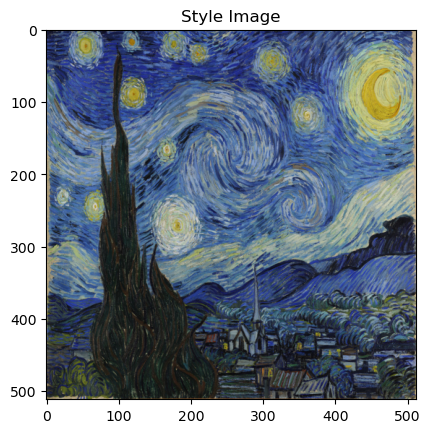

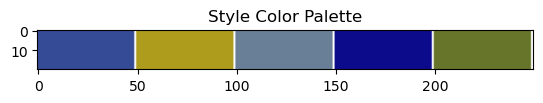

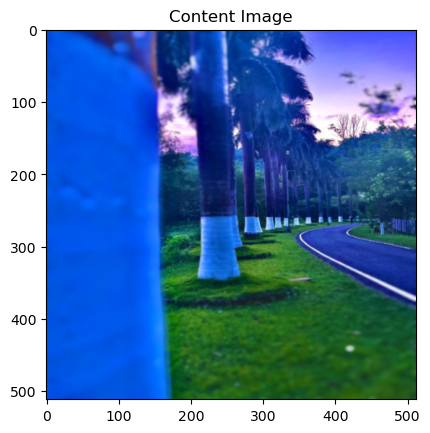

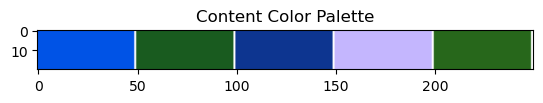

Please enter color matching order.  For example to link the first color of content palette to the third color  in style palette, please enter: 0, 2
 This will be repeated until you  enter -1.
3,2
-1


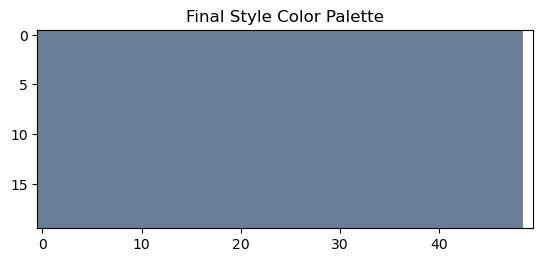

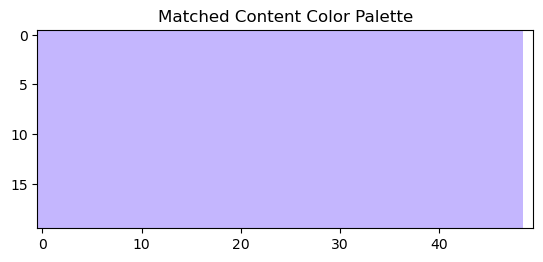

Building the style transfer model..


C:\Users\Swateya Gupta\AppData\Local\Temp\ipykernel_48584\3063816626.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Swateya Gupta\AppData\Local\Temp\ipykernel_48584\3063816626.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Content Loss: 24.655899 Color-Aware Loss: 23836.302734
run [100]:
Content Loss: 30.927795 Color-Aware Loss: 7029.931641
run [150]:
Content Loss: 36.093678 Color-Aware Loss: 3382.622070
run [200]:
Content Loss: 39.610394 Color-Aware Loss: 2093.738281
run [250]:
Content Loss: 42.290047 Color-Aware Loss: 1477.645630


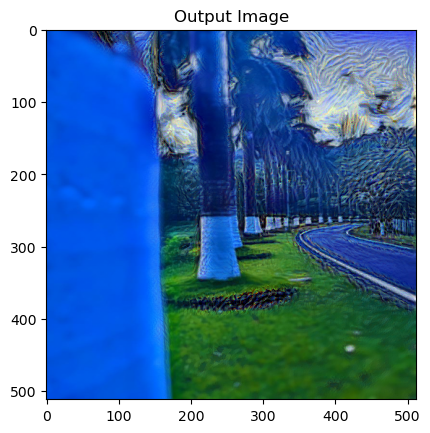

In [292]:
"""# Image Loader"""

loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])  

unloader = transforms.ToPILImage()  # reconvert into PIL image

style_img, style_palette = image_loader(STYLE_IMAGE, PALETTE_SIZE)

content_img, content_palette = image_loader(CONTENT_IMAGE, PALETTE_SIZE)


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


""" Image visualization"""

plt.ion()

style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)


for c in range(PALETTE_SIZE):
    style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        style_palette[c, :].view(1, 3, 1, 1))
    content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        content_palette[c, :].view(1, 3, 1, 1))
  

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_color_palette_vis, title='Style Color Palette')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(content_img_color_palette_vis, title='Content Color Palette')

""" Mask generation"""

if SELECT_MATCHES:
    print('Please enter color matching order. ', 
  'For example to link the first color of content palette to the third color',
  ' in style palette, please enter: 0, 2\n This will be repeated until you ',
  'enter -1.')
    user_input = input()
    matching_order_content = []
    matching_order_style = []
    while user_input != '-1':
        parts = str.split(user_input, ',')
        c = int(parts[0])
        s = int(parts[1])
        assert style_palette.shape[0] > s and content_palette.shape[0] > c
        matching_order_content.append(c)
        matching_order_style.append(s)
        user_input = input()
    sorted_style_order = np.sort(matching_order_style)
    style_palette = style_palette[sorted_style_order, :]
    sorting_inds = list(np.argsort(matching_order_style).astype(int))
    sorted_content_order = [matching_order_content[i] for i in sorting_inds]
    content_palette = content_palette[sorted_content_order, :]
    PALETTE_SIZE = len(sorted_content_order)
    style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
    content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)

    for c in range(PALETTE_SIZE):
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
              style_palette[c, :].view(1, 3, 1, 1))
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
          content_palette[c, :].view(1, 3, 1, 1))
    
    plt.figure()
    imshow(style_img_color_palette_vis, title='Final Style Color Palette')

    plt.figure()
    imshow(content_img_color_palette_vis, title='Matched Content Color Palette')

    final_palette = content_palette.clone()
    mask_generator_style = CreateMask(color_palette=style_palette)
    mask_generator_content = CreateMask(color_palette=content_palette)

else:
    final_palette = torch.cat([style_palette, content_palette], dim=0)
    if ADD_BLACK_WHITE:
        black_white = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]],
                           dtype=torch.float32, device=DEVICE)
        final_palette = torch.cat([final_palette, black_white], dim=0)

    final_palette = torch.unique(final_palette, dim=0)
    final_color_palette_vis = torch.ones((1, 3, 50, 50 * final_palette.shape[0]), 
                                     device=DEVICE)
    for c in range(final_palette.shape[0]):
        final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *final_palette[c, :].view(1, 3, 1, 1))
    plt.figure()
    imshow(final_color_palette_vis, title='Final Color Palette')
    mask_generator_style = CreateMask(color_palette=final_palette)
    mask_generator_content = CreateMask(color_palette=final_palette)


style_masks = mask_generator_style(style_img)

content_masks = mask_generator_content(content_img)

if SHOW_MASKS:
    for i in range(final_palette.shape[0]):
        plt.figure()
        imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
        plt.figure()
        imshow(content_masks[:, i, :, :], title=f'Content Mask of Color # {i}')
        

""" Loading VGG model"""

cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)


input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=DEVICE)

""" Run style transfer"""

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, style_masks, 
                            update_masks=not SELECT_MATCHES)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


save_image(output.detach().squeeze(0), 'output.png')